# Changing Class Weights

Reference: https://keras.io/guides/transfer_learning/

## Load and Split Dataset

In [1]:
!pip install tensorflow_addons

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa

# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9
MAX_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 50
BASE_LEARNING_RATE = 0.001
BATCH_SIZE = 64

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))
    
#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 192
Number of validation samples: 55
Number of test samples: 28


2021-11-27 06:15:07.607774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 06:15:07.617226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 06:15:07.617934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 06:15:07.618887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Model Definition

In [4]:
base_model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = None)
base_model.trainable = False

# Image augmentation layers
rotation_layer = tf.keras.layers.RandomRotation(0.5, seed = RANDOM_STATE)
flipping_layer = tf.keras.layers.RandomFlip(seed = RANDOM_STATE)

# Prediction layers
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

inputs = tf.keras.Input(shape = (256, 256, 3))
x = flipping_layer(inputs)
x = rotation_layer(x)
x = tf.keras.applications.resnet50.preprocess_input(x) # convert RGB to BGR, then zero-center color channel wrt ImageNet without scaling
x = base_model(x, training = False)
x = pooling_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

adam = tf.keras.optimizers.Adam(learning_rate = BASE_LEARNING_RATE)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['Precision', 'Recall', 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

### Initial Training of Classification Head

Batch Size used - 128

In [6]:
def loadDatasetEagerly(ds):
    ds_numpy = tfds.as_numpy(ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in ds_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X = np.concatenate(X_batches, axis = 0)
    y = np.concatenate(y_batches, axis = 0)
    return X, y

In [10]:
X_train, y_train = loadDatasetEagerly(train_ds)
del X_train
y_train = np.argmax(y_train, axis = 1)
labels, idx, counts = tf.unique_with_counts(y_train)
# Sort the labels and counts
sort_idx = tf.argsort(labels)
labels = tf.gather(labels, sort_idx)
counts = tf.gather(counts, sort_idx)
counts = counts.numpy().tolist()
print(labels)
print(counts)

tf.Tensor([0 1 2 3 4 5 6 7 8], shape=(9,), dtype=int64)
[769, 745, 716, 727, 732, 699, 757, 680, 6431]


In [11]:
# Calculate the class weights based on the imbalances
baseline = max(counts); print(type(counts))
class_weights = {}
for i in range(len(counts)):
    class_weights[i] = baseline/counts[i]
    
print(class_weights)

<class 'list'>
{0: 8.362808842652797, 1: 8.632214765100672, 2: 8.981843575418994, 3: 8.845942228335625, 4: 8.78551912568306, 5: 9.200286123032905, 6: 8.495376486129459, 7: 9.45735294117647, 8: 1.0}


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, 
                                                  patience = EARLY_STOPPING_PATIENCE, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

history = model.fit(train_ds, validation_data = validation_ds, 
                    epochs = MAX_EPOCHS, callbacks = [early_stopping, reduce_lr], class_weight = class_weights, batch_size = BATCH_SIZE)

Epoch 1/1000


2021-11-27 06:17:47.316700: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


192/192 [==============================] - 76s 363ms/step - loss: 5.4293 - precision: 0.6694 - recall: 0.3667 - accuracy: 0.5202 - val_loss: 1.0060 - val_precision: 0.7424 - val_recall: 0.5628 - val_accuracy: 0.6568
Epoch 2/1000
192/192 [==============================] - 65s 337ms/step - loss: 3.5660 - precision: 0.7452 - recall: 0.5495 - accuracy: 0.6511 - val_loss: 0.9100 - val_precision: 0.7593 - val_recall: 0.6142 - val_accuracy: 0.6870
Epoch 3/1000
192/192 [==============================] - 64s 334ms/step - loss: 3.1433 - precision: 0.7618 - recall: 0.5939 - accuracy: 0.6833 - val_loss: 0.9080 - val_precision: 0.7390 - val_recall: 0.6136 - val_accuracy: 0.6816
Epoch 4/1000
192/192 [==============================] - 64s 334ms/step - loss: 2.8860 - precision: 0.7761 - recall: 0.6257 - accuracy: 0.7048 - val_loss: 0.8394 - val_precision: 0.7547 - val_recall: 0.6362 - val_accuracy: 0.6976
Epoch 5/1000
192/192 [==============================] - 64s 334ms/step - loss: 2.6860 - precision

In [13]:
from sklearn.metrics import classification_report

def plotResults(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    precision = hist.history['precision']
    val_precision = hist.history['val_precision']
    recall = hist.history['recall']
    val_recall = hist.history['val_recall']

    # Plot the graph manually
    epochs = range(len(loss))

    plt.figure(figsize=(20, 20))
    plt.subplot(4, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(epochs, precision, 'r', label='Training Precision')
    plt.plot(epochs, val_precision, 'b', label='Validation Precision')
    plt.title('Training and validation Precision')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(epochs, recall, 'r', label = "Training Recall")
    plt.plot(epochs, val_recall, 'b', label='Validation Recall')
    plt.title('Training and validation Recall')
    plt.legend()

    plt.show()
    
def loadDatasetEagerly(ds):
    ds_numpy = tfds.as_numpy(ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in ds_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X = np.concatenate(X_batches, axis = 0)
    y = np.concatenate(y_batches, axis = 0)
    return X, y
    
def printClassificationReport(model, val_ds):
    # Convert validation dataset into X_val, y_val
    X_val, y_val = loadDatasetEagerly(val_ds)
    
    # Print classification report
    y_val = np.argmax(y_val, axis=1) # Convert one-hot to index
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index
    print(classification_report(y_val, y_pred))

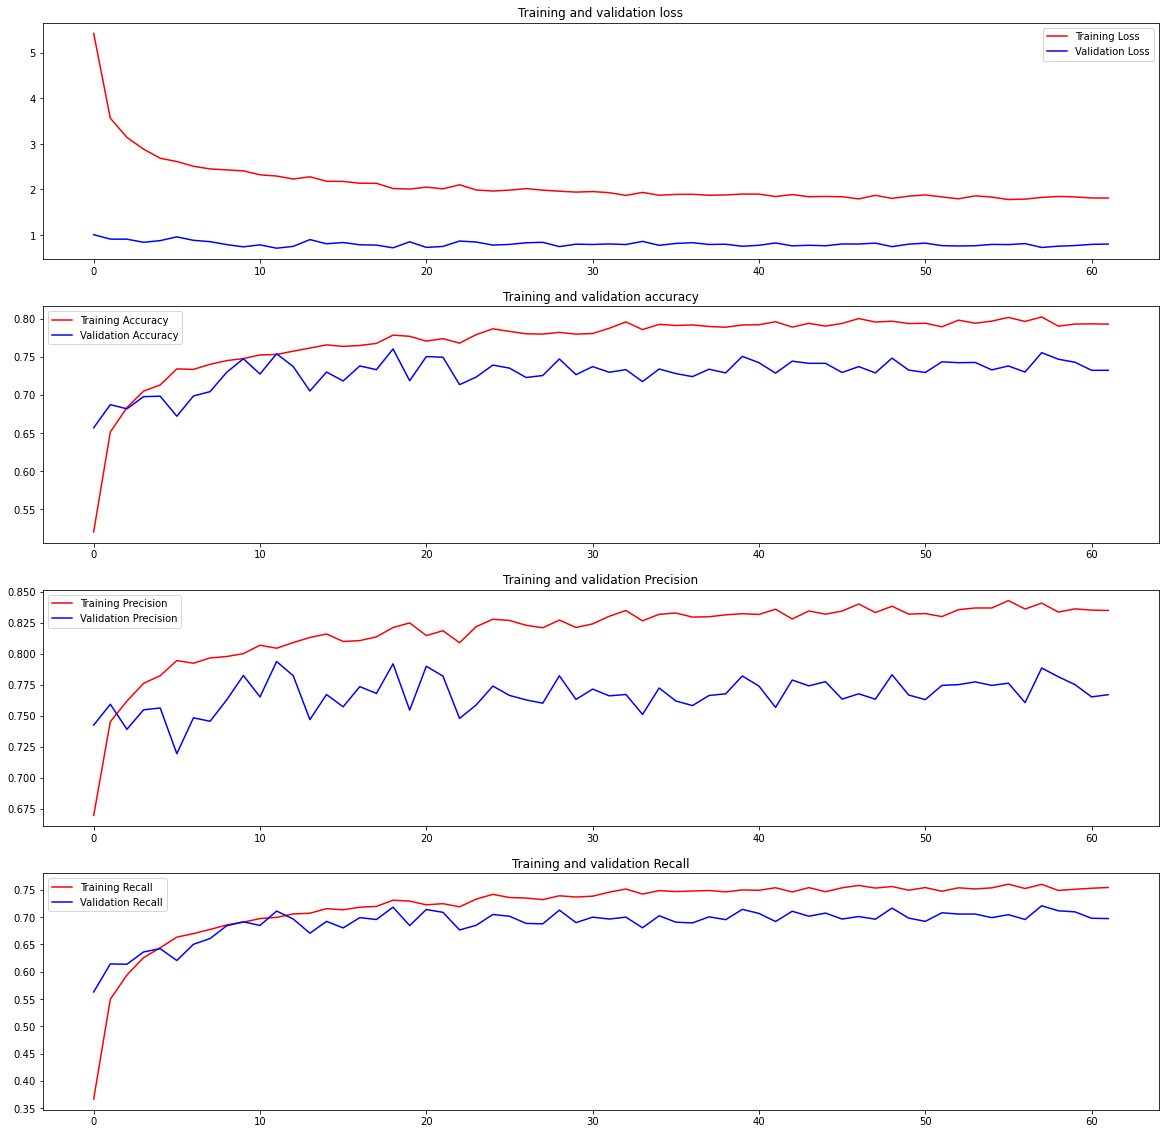

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       253
           1       0.61      0.91      0.73       229
           2       0.93      0.78      0.85       199
           3       0.72      0.69      0.71       190
           4       0.51      0.98      0.67       222
           5       0.69      0.92      0.79       212
           6       0.64      0.87      0.74       203
           7       0.55      0.80      0.65       207
           8       0.96      0.67      0.79      1787

    accuracy                           0.75      3502
   macro avg       0.70      0.82      0.74      3502
weighted avg       0.82      0.75      0.76      3502



In [14]:
plotResults(history)
printClassificationReport(model, validation_ds)

In [ ]:
model.save('imbalanced_model')

!zip -r imbalanced_model.zip imbalanced_model

2021-11-27 07:27:06.627227: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: imbalanced_model/assets


INFO:tensorflow:Assets written to: imbalanced_model/assets
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


  adding: imbalanced_model/ (stored 0%)
  adding: imbalanced_model/saved_model.pb (deflated 92%)
  adding: imbalanced_model/variables/ (stored 0%)
  adding: imbalanced_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: imbalanced_model/variables/variables.index (deflated 78%)
  adding: imbalanced_model/keras_metadata.pb (deflated 96%)
  adding: imbalanced_model/assets/ (stored 0%)
  adding: imbalanced_model/ (stored 0%)
  adding: imbalanced_model/saved_model.pb (deflated 92%)
  adding: imbalanced_model/variables/ (stored 0%)
  adding: imbalanced_model/variables/variables.data-00000-of-00001  adding: imbalanced_model/ (stored 0%)
  adding: imbalanced_model/saved_model.pb